### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Machine-Learning Based Approach

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii, Queralt Salvadó*

*Aims:*
> Our goal is to train various Machine Learning based models for each of the two sub-tasks (detection of negation and uncertainty signals, and detection of the negation and uncertainty scopes). In order to do so, we followed the implementation method described by *Enger, Velldal, and Øvrelid (2017)*, which employs a maximum-margin approach for negation detection. However, for our particular application, we also included uncertainty cues and scope detection.

*References:*
<br>
> Enger, M., Velldal, E., & Øvrelid, L. (2017). *An open-source tool for negation detection: A maximum-margin approach*. Proceedings of the Workshop on Computational Semantics Beyond Events and Roles (SemBEaR), 64–69.

---

We can erase this if you want but the thing is that we need to use the environment that queralt did. You need to write some commands to have the nlp_project (Python) as we have specific libraries.

I did that and in the preprocessing it worked but here in order to work I had to run this command above, if it is not needed just avoid them!

In [1]:
import spacy

# Check installed models
print(spacy.util.get_installed_models())


['es_core_news_sm', 'en_core_web_sm']


In [ ]:
#!python -m spacy download es_core_news_sm


In [2]:
# Import necessary libraries and functions
import json
import spacy
from collections import defaultdict
import re
import pandas as pd
from preprocessing import df_svm_neg_test, df_svm_neg_train, df_svm_neg_test, df_svm_unc_train, df_svm_unc_test, df_crf_neg_train, df_crf_neg_test, df_crf_unc_train, df_crf_unc_test

   sentence_id  token_id      word     lemma    pos prefix suffix  is_punct  \
0            0         0                      SPACE                       0   
1            1         0        nº        nº   NOUN     nº     nº         0   
2            1         1  historia  historia   NOUN    his    ria         0   
3            1         2   clinica   clinico    ADJ    cli    ica         0   
4            1         3         :         :  PUNCT      :      :         1   

   is_redacted    dep head_pos  in_single_word_cues  in_affixal_cues  \
0            0    dep    SPACE                    0                0   
1            0    det     NOUN                    0                0   
2            0   ROOT     NOUN                    0                0   
3            0   amod     NOUN                    0                0   
4            0  punct     NOUN                    0                0   

   ends_with_ment  neg_cue_label  
0               0              0  
1               0     

## CUE DETECTION USING SVM

First of all, we'll need to vectorize:

In [3]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from joblib import dump
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np

def prepare_dataframe_for_svm(df, label_col, select_features=False, n_features=None):
    drop_cols = ["sentence_id", "token_id", label_col]
    feature_dicts = df.drop(columns=drop_cols).to_dict(orient="records")
    labels = df[label_col].tolist()

    vectorizer = DictVectorizer(sparse=True)
    X = vectorizer.fit_transform(feature_dicts)
    y = labels

    print(f"Original feature matrix shape: {X.shape}")
    print(f"Class distribution: {np.bincount(y)}")

    return X, y, vectorizer

def train_and_evaluate_svm(df_train, df_test, label_col, model_name,
                          use_pca=True, n_components=50,
                          use_feature_selection=True, n_features=500,
                          use_smote=True):

    X_train, y_train, vec = prepare_dataframe_for_svm(df_train, label_col)

    X_test = vec.transform(df_test.drop(columns=["sentence_id", "token_id", label_col]).to_dict(orient="records"))
    y_test = df_test[label_col].tolist()

    print(f"Training class distribution: {np.bincount(y_train)}")
    print(f"Testing class distribution: {np.bincount(y_test)}")

    steps = []

    if use_feature_selection and X_train.shape[1] > n_features:
        print(f"Adding feature selection step (selecting {n_features} features)")
        steps.append(('feature_selection', SelectKBest(chi2, k=n_features)))

    if use_pca:
        print(f"Adding dimensionality reduction step (reducing to {n_components} components)")
        steps.append(('svd', TruncatedSVD(n_components=n_components, random_state=42)))
        steps.append(('scaler', StandardScaler()))

    if use_smote:
        print("Using SMOTE to handle class imbalance")
        steps.append(('smote', SMOTE(random_state=42)))

    svm_params = {
        'C': 1.0,
        'class_weight': 'balanced',
        'dual': False,
        'max_iter': 10000,
        'tol': 1e-4
    }
    steps.append(('svm', LinearSVC(**svm_params)))

    if use_smote:
        pipeline = ImbPipeline(steps)
    else:
        pipeline = Pipeline(steps)


    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n--- Evaluation for {model_name} ---")
    print(classification_report(y_test, y_pred, digits=3))

    dump(pipeline, f"{model_name}.joblib")
    dump(vec, f"{model_name}_vectorizer.joblib")

    return X_train, y_train, X_test, y_test, y_pred, pipeline, vec

### SVM for negation cue detection

In [4]:
X_train_negsvm, y_train_negsvm, X_test_negsvm, y_test_negsvm, y_pred_negsvm, neg_svm_model, vectorizer_neg = train_and_evaluate_svm(
    df_train=df_svm_neg_train,
    df_test=df_svm_neg_test,
    label_col="neg_cue_label",
    model_name="svm_negation_cue",
    use_pca=True,
    n_components=100,
    use_feature_selection=True,
    n_features=500,
    use_smote=True
)

Original feature matrix shape: (251970, 48864)
Class distribution: [247649   4321]
Training class distribution: [247649   4321]
Testing class distribution: [64399  1132]
Adding feature selection step (selecting 500 features)
Adding dimensionality reduction step (reducing to 100 components)
Using SMOTE to handle class imbalance

--- Evaluation for svm_negation_cue ---
              precision    recall  f1-score   support

           0      1.000     0.995     0.997     64399
           1      0.772     0.999     0.871      1132

    accuracy                          0.995     65531
   macro avg      0.886     0.997     0.934     65531
weighted avg      0.996     0.995     0.995     65531



### SVM for uncertainty cue detection

In [5]:
X_train_uncsvm, y_train_uncsvm, X_test_uncsvm, y_test_svmunc, y_pred_svmunc, unc_svm_model, vectorizer_unc = train_and_evaluate_svm(
    df_train=df_svm_unc_train,
    df_test=df_svm_unc_test,
    label_col="unc_cue_label",
    model_name="svm_uncertainty_cue",
    use_pca=True,
    n_components=100,
    use_feature_selection=True,
    n_features=500,
    use_smote=True
)

Original feature matrix shape: (251970, 48864)
Class distribution: [251284    686]
Training class distribution: [251284    686]
Testing class distribution: [251284    686]
Adding feature selection step (selecting 500 features)
Adding dimensionality reduction step (reducing to 100 components)
Using SMOTE to handle class imbalance

--- Evaluation for svm_uncertainty_cue ---
              precision    recall  f1-score   support

           0      1.000     0.927     0.962    251284
           1      0.036     0.987     0.069       686

    accuracy                          0.928    251970
   macro avg      0.518     0.957     0.516    251970
weighted avg      0.997     0.928     0.960    251970



In [6]:
from sklearn.metrics import accuracy_score
import numpy as np

# === UNCERTAINTY CUE ===
y_true_unc = y_test_svmunc
y_pred_unc = y_pred_svmunc
label_mapping_unc = {1: 'UNC', 0: 'NOT UNC'}

y_true_unc_named = [label_mapping_unc.get(y, y) for y in y_true_unc]
y_pred_unc_named = [label_mapping_unc.get(y, y) for y in y_pred_unc]

unique_labels_unc = sorted(set(y_true_unc_named + y_pred_unc_named))
per_label_accuracies_unc = {}
for label in unique_labels_unc:
    indices = [i for i, true_label in enumerate(y_true_unc_named) if true_label == label]
    true_subset = [y_true_unc_named[i] for i in indices]
    pred_subset = [y_pred_unc_named[i] for i in indices]
    acc = accuracy_score(true_subset, pred_subset)
    per_label_accuracies_unc[label] = acc

print("\nPer-label Accuracy for SVM Uncertainty Cue Detection:")
for label, acc in per_label_accuracies_unc.items():
    print(f"{label:<10}: {acc:.4f}")

# === NEGATION CUE ===
y_true_neg = y_test_negsvm
y_pred_neg = y_pred_negsvm
label_mapping_neg = {1: 'NEG', 0: 'NOT NEG'}

y_true_neg_named = [label_mapping_neg.get(y, y) for y in y_true_neg]
y_pred_neg_named = [label_mapping_neg.get(y, y) for y in y_pred_neg]

unique_labels_neg = sorted(set(y_true_neg_named + y_pred_neg_named))
per_label_accuracies_neg = {}
for label in unique_labels_neg:
    indices = [i for i, true_label in enumerate(y_true_neg_named) if true_label == label]
    true_subset = [y_true_neg_named[i] for i in indices]
    pred_subset = [y_pred_neg_named[i] for i in indices]
    acc = accuracy_score(true_subset, pred_subset)
    per_label_accuracies_neg[label] = acc

print("\nPer-label Accuracy for SVM Negation Cue Detection:")
for label, acc in per_label_accuracies_neg.items():
    print(f"{label:<10}: {acc:.4f}")



Per-label Accuracy for SVM Uncertainty Cue Detection:
NOT UNC   : 0.9274
UNC       : 0.9869

Per-label Accuracy for SVM Negation Cue Detection:
NEG       : 0.9991
NOT NEG   : 0.9948


## SCOPE DETECTION USING CRF

In [7]:
#pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00


We'll use CRF BIO tagging:

**BIO tagging** is a way to label each word in a sentence to show if it is part of a scope (like negation or uncertainty). The labels are:

* **B** for the **Beginning** of the scope
* **I** for **Inside** the scope
* **O** for **Outside** the scope

We use BIO tagging to help machine learning models, like **CRFs (Conditional Random Fields)**, understand where a scope starts and ends. For example, if a sentence has a negation like “No tiene fiebre”, BIO tagging shows that “No” is the beginning (**B-SCOPE**) and “tiene fiebre” is inside the scope (**I-SCOPE**), while other words would be labeled **O** if they are not part of it.

Using BIO makes it easier for the model to learn patterns and detect complete scopes correctly, not just single words.


In [8]:
#   IM GETTING ALL THE NEGATION AND THE UNC CUES FROM TRAIN DATAFRAME,
#   maybe it should be done with the svm but i dont how.
neg_cues = set()
unc_cues = set()
for _, row in df_svm_neg_train.iterrows():
    if row['neg_cue_label'] == 1:
        neg_cues.add(row['word'].lower())

for _, row in df_svm_unc_train.iterrows():
    if row['unc_cue_label'] == 1:
        unc_cues.add(row['word'].lower())


In [9]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics

def to_bio_labels(labels, label_type="SCOPE"):
    # Convert lists of binary labels (0/1) into BIO tagging format with custom suffixes
    bio_labels = []

    # Map original suffixes to new ones
    if "neg" in label_type.lower():
        prefix = "NSCO"   # Instead of NEG_SCOPE
    elif "unc" in label_type.lower():
        prefix = "UNSCO"  # Instead of UNC_SCOPE
    else:
        prefix = label_type.upper()  # fallback

    for sent in labels:
        bio = []
        prev = 0
        for i, tag in enumerate(sent):
            if tag == 1:
                if i == 0 or prev == 0:
                    bio.append(f'B-{prefix}')
                else:
                    bio.append(f'I-{prefix}')
            else:
                bio.append('O')
            prev = tag
        bio_labels.append(bio)
    return bio_labels

def df_to_crf_format(df, task, neg_cues=neg_cues, unc_cues=unc_cues):
    """
    Convert a DataFrame into a list of feature dictionaries per sentence for CRF input.
    Includes original features + contextual features + lexicon-based features.

    Parameters:
        df (pd.DataFrame): must contain columns like 'word', 'pos', 'prefix', 'suffix', etc.

    Returns:
        List of list of feature dicts (one per token, grouped by sentence)
    """
    sentences = []
    grouped = df.groupby("sentence_id")

    for _, group in grouped:
        sentence = []
        group = group.reset_index(drop=True)  # Reset index so we can use idx in loop

        for idx, row in group.iterrows():
            word_lower = row['word'].lower()

            features = {
                'word.lower()': word_lower,
                'word.isupper()': row['word'].isupper(),
                'word.istitle()': row['word'].istitle(),
                'pos': row['pos'],
                'pos_prefix': row['pos'][:2] if isinstance(row['pos'], str) else 'NA',
                'prefix': row['prefix'],
                'suffix': row['suffix'],
                'is_punct': row['is_punct'],
                'in_single_word_cues': row['in_single_word_cues'],
                'in_affixal_cues': row['in_affixal_cues'],
                'ends_with_ment': row['ends_with_ment'],
                'has_neg_prefix': word_lower.startswith(('un', 'in', 'non', 'dis')),
                'has_neg_suffix': word_lower.endswith(('less', "n't")),
                'is_modal': word_lower in unc_cues if task == "UNC" else word_lower in neg_cues
            }

            # dependency features
            if 'dep' in row and 'head_word' in row and 'head_pos' in row:
                features.update({
                    'dep_label': row['dep'],
                    'head_word': str(row['head_word']).lower(),
                    'head_pos': row['head_pos']
                })

            # Contextual features: previous and next token
            if idx > 0:
                prev_row = group.iloc[idx - 1]
                features.update({
                    '-1:word.lower()': prev_row['word'].lower(),
                    '-1:pos': prev_row['pos']
                })
            else:
                features['BOS'] = True  # Beginning of sentence

            if idx < len(group) - 1:
                next_row = group.iloc[idx + 1]
                features.update({
                    '+1:word.lower()': next_row['word'].lower(),
                    '+1:pos': next_row['pos']
                })
            else:
                features['EOS'] = True  # End of sentence

            sentence.append(features)
        sentences.append(sentence)

    return sentences


def df_to_labels(df, label_col):
    # Extracts label sequences from the DataFrame, grouped by sentence
    label_sequences = []
    grouped = df.groupby("sentence_id")
    for _, group in grouped:
        label_list = group[label_col].tolist()
        label_sequences.append(label_list)
    return label_sequences


In [10]:
# Train + evaluate CRF model
def train_and_evaluate_crf(df_train, df_test, label_col):
    # Trains and evaluates a CRF model for BIO tagging using specified label column (e.g., 'neg_scope_label')
    scope_type = "NEG" if "neg" in label_col.lower() else "UNC"

    X_train = df_to_crf_format(df_train, scope_type)
    y_train_raw = df_to_labels(df_train, label_col)
    y_train = to_bio_labels(y_train_raw, label_type=scope_type)

    X_test = df_to_crf_format(df_test, scope_type)
    y_test_raw = df_to_labels(df_test, label_col)
    y_test = to_bio_labels(y_test_raw, label_type=scope_type)

    crf = CRF(algorithm='lbfgs',
              c1=0.1, c2=0.1,
              max_iterations=100, all_possible_transitions=True)

    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)

    print(f"CRF Evaluation for: {label_col.upper()}")
    print(metrics.flat_classification_report(y_test, y_pred, digits=4))

    return X_test, y_test, y_pred  # Return these variables for further use


### CRF for negation scope detection

In [11]:
# CRF BIO tagging evaluation for NEGATION scopes
X_test_NEG, y_test_NEG, y_pred_NEG = train_and_evaluate_crf(df_crf_neg_train, df_crf_neg_test, "neg_scope_label")

CRF Evaluation for: NEG_SCOPE_LABEL
              precision    recall  f1-score   support

      B-NSCO     0.9633    0.9066    0.9341      1071
      I-NSCO     0.8965    0.7831    0.8360      2522
           O     0.9897    0.9958    0.9927     61938

    accuracy                         0.9862     65531
   macro avg     0.9498    0.8952    0.9209     65531
weighted avg     0.9857    0.9862    0.9857     65531



### CRF for uncertainty scope detection

In [12]:
# CRF BIO tagging evaluation for UNCERTAINTY scopes
X_test_UNC, y_test_UNC, y_pred_UNC = train_and_evaluate_crf(df_crf_unc_train, df_crf_unc_test, "unc_scope_label")

CRF Evaluation for: UNC_SCOPE_LABEL
              precision    recall  f1-score   support

     B-UNSCO     0.7963    0.3333    0.4699       129
     I-UNSCO     0.6590    0.3936    0.4928       437
           O     0.9947    0.9985    0.9966     64965

    accuracy                         0.9932     65531
   macro avg     0.8167    0.5751    0.6531     65531
weighted avg     0.9921    0.9932    0.9922     65531



In [13]:
# TABLE WITH ALL COMBINED EXCLUDING THE OUTOFSCOPE:
# Combine the BIO label sequences
y_test_all = y_test_NEG + y_test_UNC
y_pred_all = y_pred_NEG + y_pred_UNC

# Get all labels except 'O'
all_labels = set(label for seq in y_test_all for label in seq if label != 'O')
all_labels = sorted(all_labels)

# Print overall evaluation
print("Overall Evaluation (NEG + UNC scopes):")
print(metrics.flat_classification_report(
    y_test_all, y_pred_all, labels=all_labels, digits=4))

Overall Evaluation (NEG + UNC scopes):
              precision    recall  f1-score   support

      B-NSCO     0.0069    0.0065    0.0067      1071
     B-UNSCO     0.0000    0.0000    0.0000       129
      I-NSCO     0.0159    0.0139    0.0148      2522
     I-UNSCO     0.0000    0.0000    0.0000       437

   micro avg     0.0119    0.0101    0.0109      4159
   macro avg     0.0057    0.0051    0.0054      4159
weighted avg     0.0114    0.0101    0.0107      4159



In [14]:
# Flatten lists
true_labels = [label for seq in y_test_all for label in seq]
pred_labels = [label for seq in y_pred_all for label in seq]

# Unique labels to check
labels = sorted(set(label for label in true_labels if label != 'O'))

# Calculate per-label accuracy
label_accuracies = {}
for label in labels:
    total = sum(1 for t in true_labels if t == label)
    correct = sum(1 for t, p in zip(true_labels, pred_labels) if t == label and p == label)
    label_accuracies[label] = correct / total if total > 0 else 0.0

# Print nicely
for label, acc in label_accuracies.items():
    print(f"{label}: {acc:.4f}")

B-NSCO: 0.0065
B-UNSCO: 0.0000
I-NSCO: 0.0139
I-UNSCO: 0.0000


## Printing CRF Predictions vs. True labels
We display sample sentences with predicted and true BIO tags shown as `[true_tag|pred_tag]` next to each word, only if at least one tag isn't `'O'`. This highlights where the model correctly identifies scopes or makes mistakes, helping us quickly assess its performance on meaningful cases.

In [15]:
def print_crf_predictions(df, y_true, y_pred, sentence_idx=0):
    """
    Print the whole sentence in one line, adding true and predicted BIO tags in brackets next to tokens
    only if the tags are not 'O'.
    Format per token: word[true_tag|pred_tag] if either tag != 'O', else just word.
    """
    grouped = df.groupby("sentence_id")
    sentence_ids = list(grouped.groups.keys())

    if sentence_idx >= len(sentence_ids):
        print(f"Invalid sentence index {sentence_idx}. Max allowed: {len(sentence_ids) - 1}")
        return

    sentence_id = sentence_ids[sentence_idx]
    sentence_df = grouped.get_group(sentence_id).reset_index(drop=True)

    output_tokens = []
    for i, row in sentence_df.iterrows():
        word = row['word']
        true_label = y_true[sentence_idx][i]
        pred_label = y_pred[sentence_idx][i]

        # Show tags only if either true or pred label is not 'O'
        if true_label != 'O' or pred_label != 'O':
            display_word = f"{word} [{true_label}|{pred_label}]"
        else:
            display_word = word

        output_tokens.append(display_word)

    print(f"\n--- Sentence ID {sentence_id} ---")
    print(" ".join(output_tokens))

In [16]:
shown = 0
max_to_show = 10

for i in range(len(y_test_NEG)):
    if any(tag != 'O' for tag in y_test_NEG[i]) or any(tag != 'O' for tag in y_pred_NEG[i]):
        print_crf_predictions(df_crf_neg_test, y_test_NEG, y_pred_NEG, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : dona data de naixement : 12.05.1977 edat : 42 anys procedencia aguts servei obstetricia data d'ingres 27.09.2019 data d'alta 01.10.2019 13:00:00 ates per * * * * * * * * * * * * * * * * * , * * * * * * * * * * * * * * ; * * * * * * * * * * * * * * * * * , * * * * * informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no alergias [B-NSCO|B-NSCO] medicamentosas [I-NSCO|I-NSCO] conocidas antcededentes medico-quirurgicos : protesis mamaria , adenoidectomia niega habitos [B-NSCO|B-NSCO] toxicos [I-NSCO|I-NSCO] medicacio habitual anafranil25 mg/ diario .

--- Sentence ID 10 ---
vih [B-NSCO|B-NSCO] negativo .

--- Sentence ID 11 ---
serologias : rubeola no inmune [B-NSCO|B-NSCO] , toxoplasma no immune [B-NSCO|B-NSCO] , lues [B-NSCO|B-NSCO] vih [I-NSCO|I-NSCO] , [I-NSCO|I-NSCO] vhb [I-NSCO|I-NSCO] y [I-NSCO|I-NSCO] vhc [I-NSCO|I-

In [17]:
shown = 0
max_to_show = 10

for i in range(len(y_test_UNC)):
    if any(tag != 'O' for tag in y_test_UNC[i]) or any(tag != 'O' for tag in y_pred_UNC[i]):
        print_crf_predictions(df_crf_neg_test, y_test_UNC, y_pred_UNC, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


--- Sentence ID 138 ---
dado cuadro clinico y analitico que podria ser [B-UNSCO|O] compatible [I-UNSCO|O] con [I-UNSCO|O] sd [I-UNSCO|O] mononucleosido [I-UNSCO|O] se amplia estudio con determinacion de pcr de parvovirus b19 , toxoplasma y vhh-6 , con resultados pendientes .

--- Sentence ID 140 ---
orientacio diagnostica b34.9 infeccio virica no especificada neutropenia autolimitada fiebre de origen desconocido , posible viriasis [B-UNSCO|B-UNSCO] . [O|I-UNSCO]

--- Sentence ID 156 ---
antecedentes patologicos - elevacion de transaminasas posiblemente secundario [B-UNSCO|O] a [I-UNSCO|O] consumo [I-UNSCO|O] enolico [I-UNSCO|O] . [I-UNSCO|O]

--- Sentence ID 188 ---
hipoestesia simetrica en mmii hasta abdomen ( sin claro nivel [B-UNSCO|O] ) [I-UNSCO|O] .

--- Sentence ID 193 ---
atrofia hipotenar y posible atrofia [B-UNSCO|B-UNSCO] interoseos [I-UNSCO|I-UNSCO] ( paciente refiere que siempre ha permanecido asi ) .

--- Sentence ID 228 ---
por las caracteristicas encontradas , sugiere o

### Overall Results: SVM + CRF

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def flatten(seq_list):
    return [label for seq in seq_list for label in seq]

# Cue detection: true and predicted labels
cue_true = df_svm_neg_test["neg_cue_label"].tolist() + df_svm_unc_test["unc_cue_label"].tolist()

X_test_neg = vectorizer_neg.transform(
    df_svm_neg_test.drop(columns=["sentence_id", "token_id", "neg_cue_label"]).to_dict(orient="records")
)
X_test_unc = vectorizer_unc.transform(
    df_svm_unc_test.drop(columns=["sentence_id", "token_id", "unc_cue_label"]).to_dict(orient="records")
)
cue_pred = list(neg_svm_model.predict(X_test_neg)) + list(unc_svm_model.predict(X_test_unc))

# Scope detection: true and predicted
scope_true = flatten(y_test_NEG) + flatten(y_test_UNC)
scope_pred = flatten(y_pred_NEG) + flatten(y_pred_UNC)

# Filter out neutral classes
cue_true_filtered = [true for true, pred in zip(cue_true, cue_pred) if true != '0']
cue_pred_filtered = [pred for true, pred in zip(cue_true, cue_pred) if true != '0']

scope_true_filtered = [true for true, pred in zip(scope_true, scope_pred) if true != 'O']
scope_pred_filtered = [pred for true, pred in zip(scope_true, scope_pred) if true != 'O']

# Combine filtered
y_true_all = cue_true_filtered + scope_true_filtered
y_pred_all = cue_pred_filtered + scope_pred_filtered

# Calculate metrics
accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, average="weighted", zero_division=0)
recall = recall_score(y_true_all, y_pred_all, average="weighted", zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, average="weighted", zero_division=0)

# Output
print("\nFiltered Overall Evaluation (Cue + Scope Detection):")
print(f"{'Metric':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print(f"{'Overall':<10} {accuracy:.4f}    {precision:.4f}    {recall:.4f}    {f1:.4f}")


Filtered Overall Evaluation (Cue + Scope Detection):
Metric     Accuracy   Precision  Recall     F1 Score  
Overall    0.9391    0.9948    0.9391    0.9636


In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_task_confusion_matrices(
    y_test_negsvm, y_pred_negsvm,
    y_test_svmunc, y_pred_svmunc,
    y_test_NEG, y_pred_NEG,
    y_test_UNC, y_pred_UNC
):
    def binary_label_map(y, label_type):
        return [f"{label_type}" if v == 1 else f"NOT {label_type}" for v in y]

    def flatten(seqs):
        return [label for seq in seqs for label in seq]

    def plot_cm(ax, y_true, y_pred, labels, title):
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Convert 0/1 to string labels
    y_test_neg_named = binary_label_map(y_test_negsvm, "NEG")
    y_pred_neg_named = binary_label_map(y_pred_negsvm, "NEG")
    y_test_unc_named = binary_label_map(y_test_svmunc, "UNC")
    y_pred_unc_named = binary_label_map(y_pred_svmunc, "UNC")

    # Flatten scope labels
    y_test_neg_scope = flatten(y_test_NEG)
    y_pred_neg_scope = flatten(y_pred_NEG)
    y_test_unc_scope = flatten(y_test_UNC)
    y_pred_unc_scope = flatten(y_pred_UNC)

    # Label sets
    neg_cue_labels = ["NOT NEG", "NEG"]
    unc_cue_labels = ["NOT UNC", "UNC"]
    neg_scope_labels = sorted(set(y_test_neg_scope + y_pred_neg_scope))
    unc_scope_labels = sorted(set(y_test_unc_scope + y_pred_unc_scope))

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    plot_cm(axs[0, 0], y_test_neg_named, y_pred_neg_named, neg_cue_labels, "Confusion Matrix for NEG")
    plot_cm(axs[0, 1], y_test_unc_named, y_pred_unc_named, unc_cue_labels, "Confusion Matrix for UNC")
    plot_cm(axs[1, 0], y_test_neg_scope, y_pred_neg_scope, neg_scope_labels, "Confusion Matrix for NSCO")
    plot_cm(axs[1, 1], y_test_unc_scope, y_pred_unc_scope, unc_scope_labels, "Confusion Matrix for USCO")

    plt.tight_layout()
    plt.show()


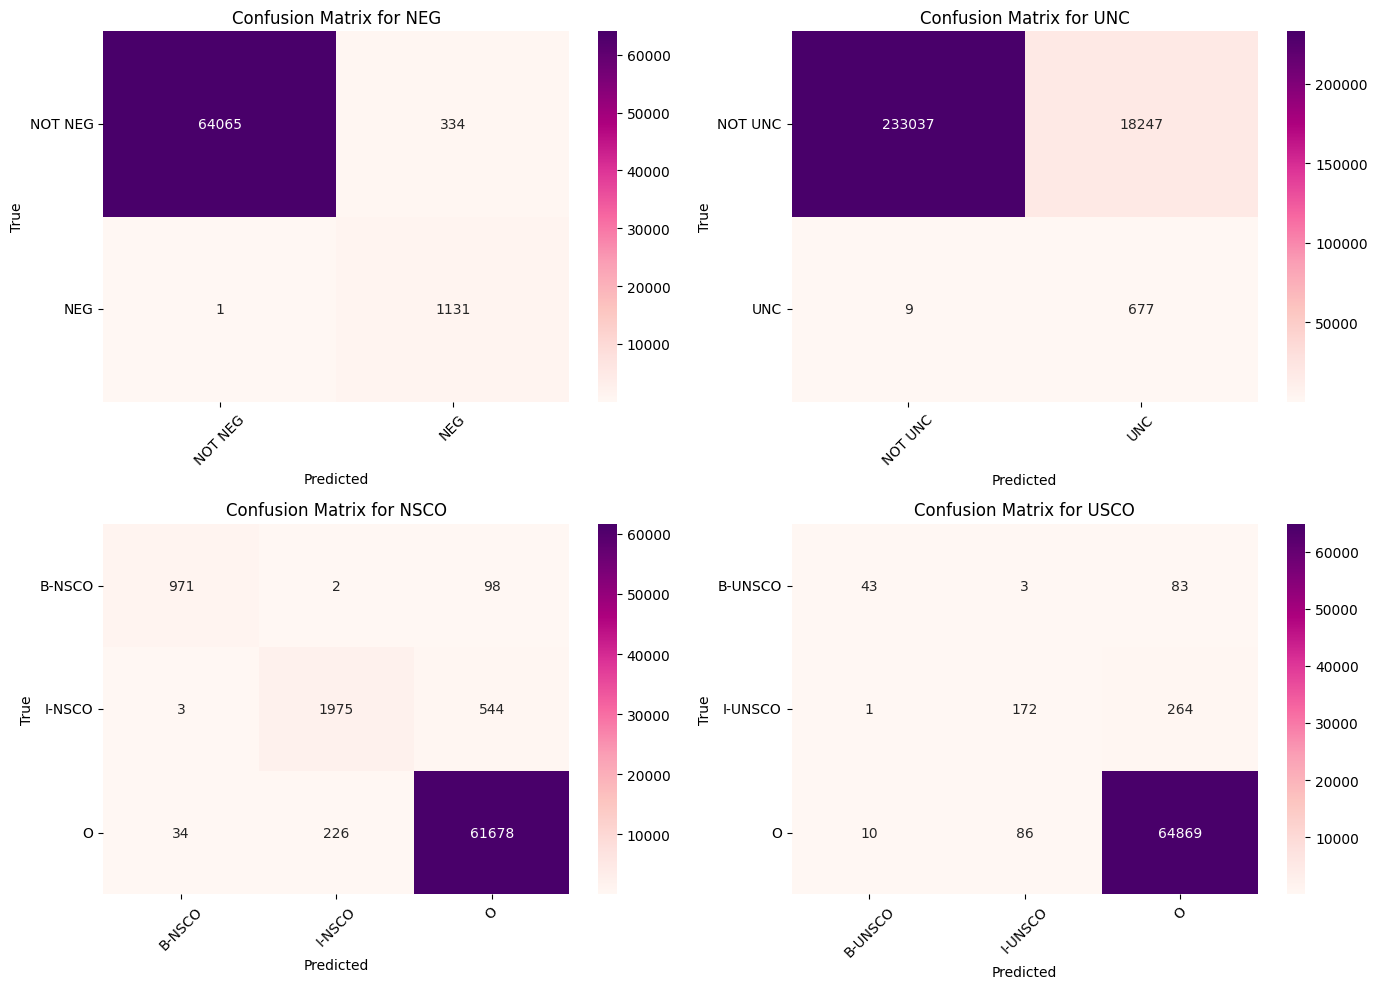

In [21]:
plot_task_confusion_matrices(
    y_test_negsvm, y_pred_negsvm,
    y_test_svmunc, y_pred_svmunc,
    y_test_NEG, y_pred_NEG,
    y_test_UNC, y_pred_UNC
)
